## Linear Regression Model

### Imports and Utils

In [1]:
"""
Importing the necessary libraries
"""
import os
from time import time
import pickle

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

try:
    import plotly.express as px
except ModuleNotFoundError:
    %pip install plotly
    import plotly.express as px

try:
    from ucimlrepo import fetch_ucirepo
except ModuleNotFoundError:
    %pip install ucimlrepo
    from ucimlrepo import fetch_ucirepo

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Plotting the metrics
def plot_metrics(Metrics: pd.DataFrame, title: str):
    """
    Metrics: pd.DataFrame: Metrics computed of the model.
    title: string: X-axis of the plots.
    """
        
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    Metrics.iloc[:, :2].plot(ax=axs[0])
    axs[0].set_xlabel(f'{title} of Linear Regression')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].set_title(f'Mean Squared Error vs {title} of Linear Regression')

    Metrics.iloc[:, 2:].plot(ax=axs[1])
    axs[1].set_xlabel(f'{title} of Linear Regression')
    axs[1].set_ylabel('Time Taken (s)')
    axs[1].set_title(f'Time Taken vs {title} of Linear Regression')
        
    plt.tight_layout()
    plt.show()

### Dataset Loading and Preprocessing

In [3]:
target = 'mpg'

# Dataset 1 Auto MPG
# '''
dataset = fetch_ucirepo(id=9)
dataset = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

# Cleaning the data
dataset = dataset.replace('?', np.nan).dropna()
dataset['horsepower'] = pd.to_numeric(dataset['horsepower'])

# Print the first few records
print(dataset.head())

# Print the size of the dataset
print("size of the dataset: ", dataset.shape)
# '''

   displacement  cylinders  horsepower  weight  acceleration  model_year  \
0         307.0          8       130.0    3504          12.0          70   
1         350.0          8       165.0    3693          11.5          70   
2         318.0          8       150.0    3436          11.0          70   
3         304.0          8       150.0    3433          12.0          70   
4         302.0          8       140.0    3449          10.5          70   

   origin   mpg  
0       1  18.0  
1       1  15.0  
2       1  18.0  
3       1  16.0  
4       1  17.0  
size of the dataset:  (392, 8)


In [4]:
# Data Visualization
for column in dataset.drop(target, axis=1).columns:
    fig = px.density_heatmap(dataset, x=column, y=target, color_continuous_scale='magma_r')
    fig.show()

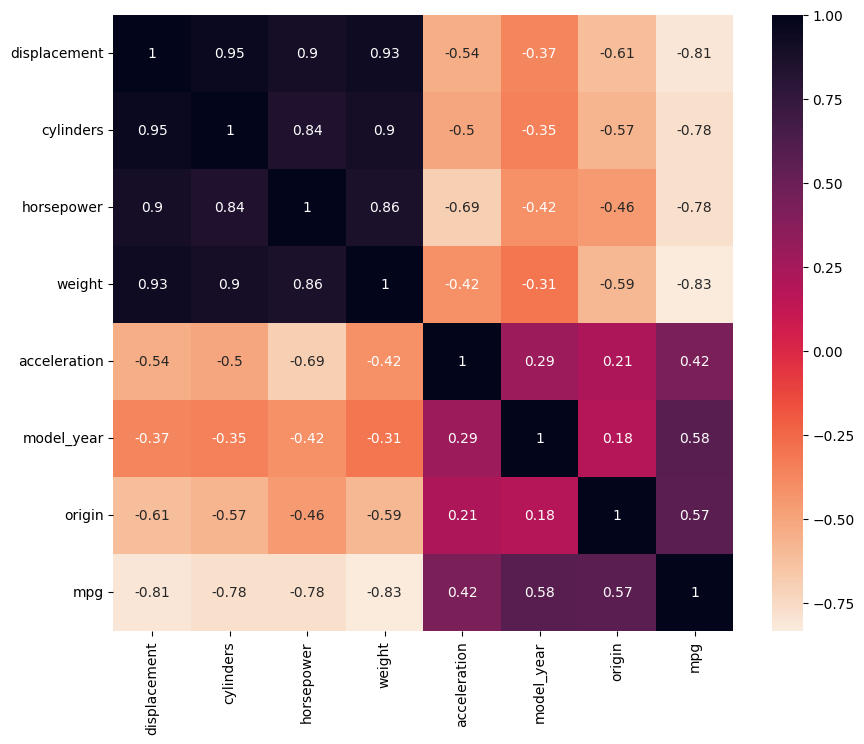

In [5]:
# Checking coorelation within the dataset
dataset_corr = dataset.corr()
plt.figure(figsize=(10,8))
sns.heatmap(dataset_corr, cmap='rocket_r',annot=True)
plt.show()

In [6]:
# Feature selection
threshold = 0.35
target_corr = abs(dataset_corr.iloc[:, -1])
features = target_corr[target_corr > threshold].index

# Display the relevant features
dataset = dataset[features]
print("Relevant Features:\n", features.values)

Relevant Features:
 ['displacement' 'cylinders' 'horsepower' 'weight' 'acceleration'
 'model_year' 'origin' 'mpg']


In [7]:
# Extract X and Y from dataset
X = dataset.iloc[:, :-1]
Y = dataset.iloc[:, -1]

# Split the dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

# Print the first few records
print(f'Feature Train Dataset:\n{X_train.head()}\nsize: {X_train.shape}\n')
print(f'Target Train Dataset:\n{Y_train.head()}\nsize: {Y_train.shape}\n')
print(f'Feature Test Dataset:\n{X_test.head()}\nsize: {X_test.shape}\n')
print(f'Target Test Dataset:\n{Y_test.head()}\nsize: {Y_test.shape}\n')

# Apply Scaler of the dataset
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature Train Dataset:
     displacement  cylinders  horsepower  weight  acceleration  model_year  \
260         225.0          6       110.0    3620          18.7          78   
184         140.0          4        92.0    2572          14.9          76   
174         171.0          6        97.0    2984          14.5          75   
64          318.0          8       150.0    4135          13.5          72   
344          86.0          4        64.0    1875          16.4          81   

     origin  
260       1  
184       1  
174       1  
64        1  
344       1  
size: (313, 7)

Target Train Dataset:
260    18.6
184    25.0
174    18.0
64     15.0
344    39.0
Name: mpg, dtype: float64
size: (313,)

Feature Test Dataset:
     displacement  cylinders  horsepower  weight  acceleration  model_year  \
79           96.0          4        69.0    2189          18.0          72   
276         121.0          4       115.0    2795          15.7          78   
248          91.0          4  

In [8]:
# Convert the data into tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32).to(device)

# Print shapes of the tensors
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_train shape: torch.Size([313, 7])
Y_train shape: torch.Size([313])
X_test shape: torch.Size([79, 7])
Y_test shape: torch.Size([79])


### Model Creation and Training

In [9]:
class LinearRegression(nn.Module):
    """
    A Linear Regressor.
    """

    def __init__(self, in_features: int, out_features: int, learning_rate: float = 0.01):
        """
        Constructor for Linear Regression.

        in_features: int: The number of input features.
        out_features: int: The number of output features.
        """
        
        super(LinearRegression, self).__init__()
        self.W = torch.tensor(np.random.randn(out_features, in_features), dtype=torch.float32).to(device)
        self.b = torch.tensor(np.random.randn(1, out_features), dtype=torch.float32).to(device)
        self.lr = learning_rate
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        X: torch.Tensor: The input tensor.
        """

        return torch.matmul(X, self.W.T) + self.b
    
    def fit(self, X: torch.Tensor, y: torch.Tensor, epochs: int = 100, print_cost: bool = False):
        """
        X: torch.Tensor: The input tensor.
        """

        X, y = X.reshape(-1, self.in_features).to(device), y.reshape(-1, self.out_features).to(device)

        Cost = []
        for i in range(epochs):
            # Forward pass
            predictions = self.forward(X)
            cost = torch.mean((predictions - y) ** 2)/2
            Cost.append(cost.item())

            # Backward pass
            dW = torch.matmul((predictions - y).T, X)/X.shape[0]
            db = torch.mean(predictions - y, dim=0, keepdim=True)

            # Update the weights
            self.W = (self.W - self.lr * dW).to(device)
            self.b = (self.b - self.lr * db).to(device)

            # Print the cost
            if print_cost and (i+1) % 100 == 0:
                print(f'Cost at epoch {i+1}: {round(cost.item(), 3)}')
                print("\n------------------------------------------------------------\n")

        return Cost
    
    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        X: torch.Tensor: The input tensor.
        """

        return self.forward(X)

In [10]:
# Define the model for Linear Regression
model = LinearRegression(in_features=X_train.shape[1], out_features=1, learning_rate=0.01).to(device)

In [11]:
# Training the model
cost = model.fit(X_train, Y_train, epochs=1000, print_cost=True)

# Calculating the metrics
Y_pred = model.predict(X_train).detach()
print(f"Train MSE: {mean_squared_error(Y_train.cpu(), Y_pred.cpu())}")

Cost at epoch 100: 46.074

------------------------------------------------------------

Cost at epoch 200: 11.574

------------------------------------------------------------

Cost at epoch 300: 6.803

------------------------------------------------------------

Cost at epoch 400: 6.073

------------------------------------------------------------

Cost at epoch 500: 5.908

------------------------------------------------------------

Cost at epoch 600: 5.833

------------------------------------------------------------

Cost at epoch 700: 5.78

------------------------------------------------------------

Cost at epoch 800: 5.738

------------------------------------------------------------

Cost at epoch 900: 5.703

------------------------------------------------------------

Cost at epoch 1000: 5.674

------------------------------------------------------------

Train MSE: 11.347249984741211


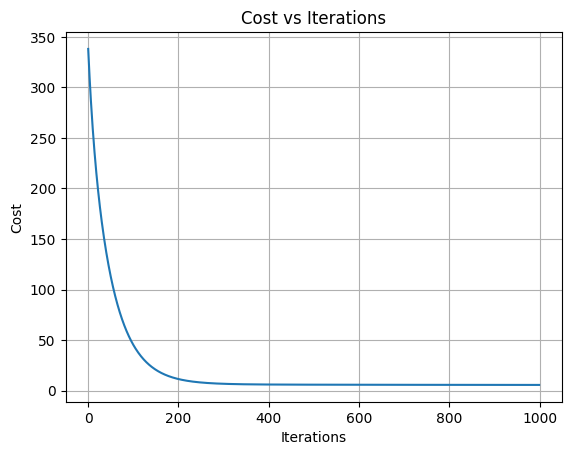

In [12]:
# Plot the cost vs iterations
plt.plot(np.arange(len(cost)), cost)
plt.title('Cost vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()

### Testing and Plotting

In [13]:
# Predicting the values
Y_pred = model.predict(X_test).detach()

# Calculating the metrics
print(f'Test MSE: {mean_squared_error(Y_test.cpu(), Y_pred.cpu())}')

Test MSE: 11.520204544067383


In [14]:
# Train the model with different hyperparameters
Metrics = {}
Costs = {}
for lr in np.arange(0.001, 0.111, 0.01):
    print(f"Linear Regression with learning rate {round(lr, 3)}")

    # Defining the model for Linear Regression
    model = LinearRegression(in_features=X_train.shape[1], out_features=1, learning_rate=lr).to(device)
    start = time()
    cost = model.fit(X_train, Y_train, epochs=100)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train).detach()
    train_mse = mean_squared_error(Y_train.cpu(), Y_pred.cpu())
    start = time()
    Y_pred = model.predict(X_test).detach()
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test.cpu(), Y_pred.cpu())

    # Storing the metrics
    Metrics[lr] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    Costs[lr] = cost
    print(f"Train MSE: {round(train_mse, 3)}")
    print(f"Test MSE: {round(test_mse, 3)}")

    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T
Costs = pd.DataFrame(Costs)

Linear Regression with learning rate 0.001
Train MSE: 532.0399780273438
Test MSE: 477.885009765625

------------------------------------------------------------

Linear Regression with learning rate 0.011
Train MSE: 76.69100189208984
Test MSE: 68.18099975585938

------------------------------------------------------------

Linear Regression with learning rate 0.021
Train MSE: 20.187000274658203
Test MSE: 17.690000534057617

------------------------------------------------------------

Linear Regression with learning rate 0.031
Train MSE: 13.420999526977539
Test MSE: 12.885000228881836

------------------------------------------------------------

Linear Regression with learning rate 0.041
Train MSE: 11.878999710083008
Test MSE: 11.968000411987305

------------------------------------------------------------

Linear Regression with learning rate 0.051
Train MSE: 11.701000213623047
Test MSE: 12.064000129699707

------------------------------------------------------------

Linear Regressi

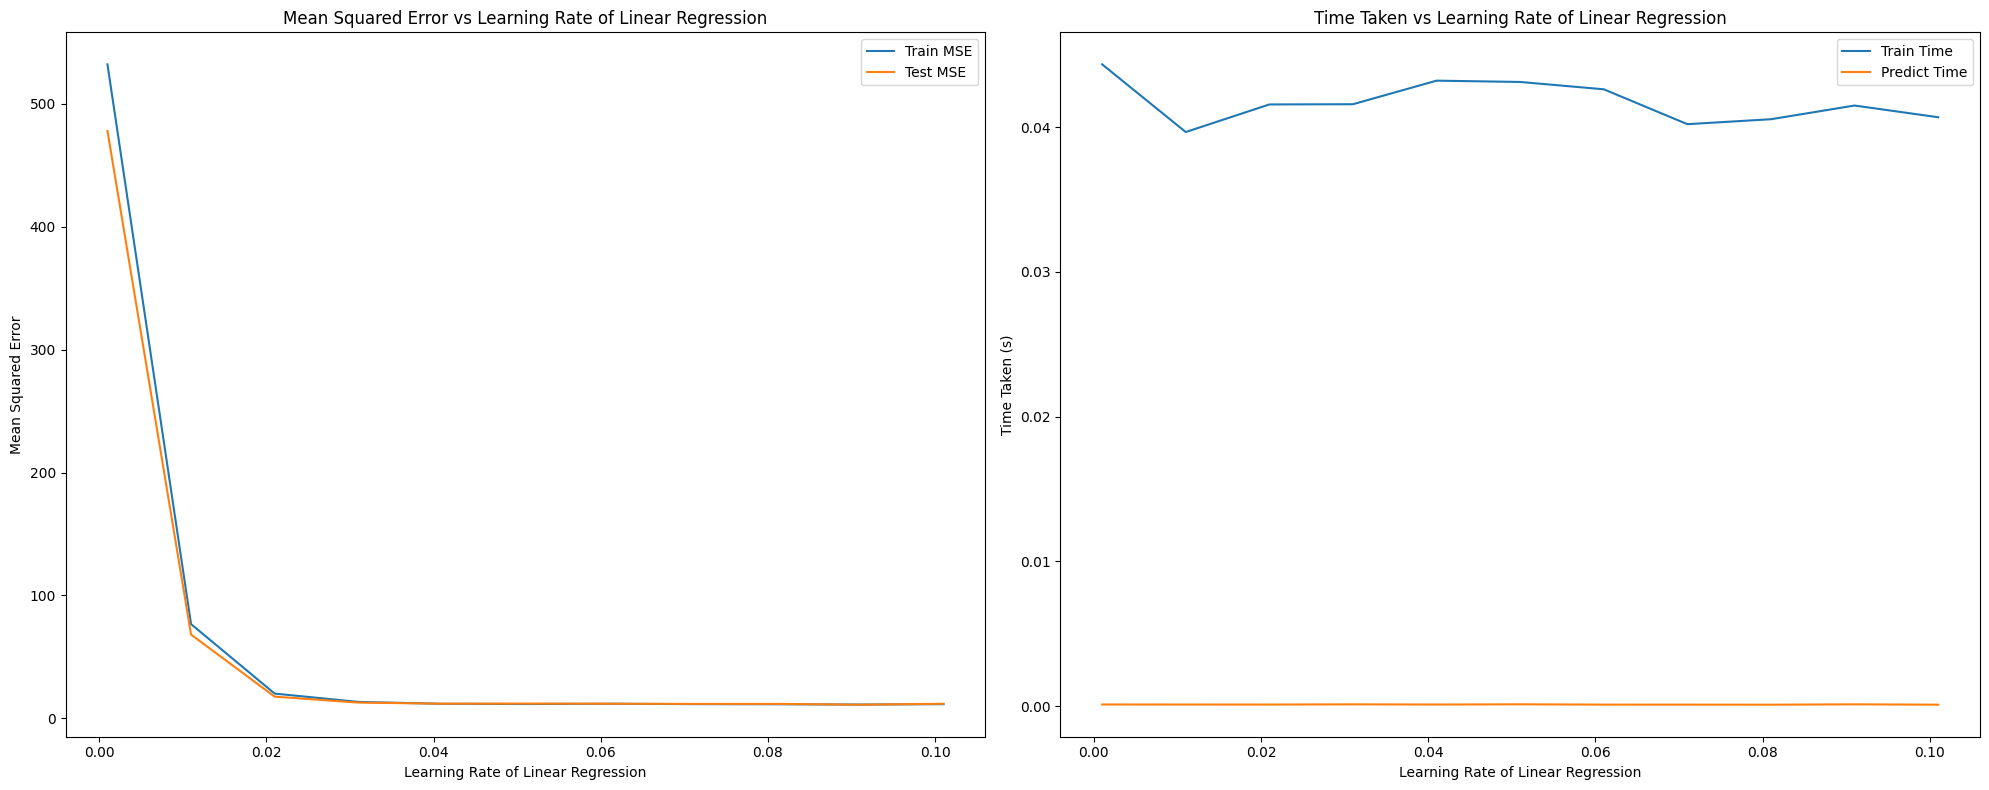

In [15]:
# Plotting the metrics
plot_metrics(Metrics, 'Learning Rate')

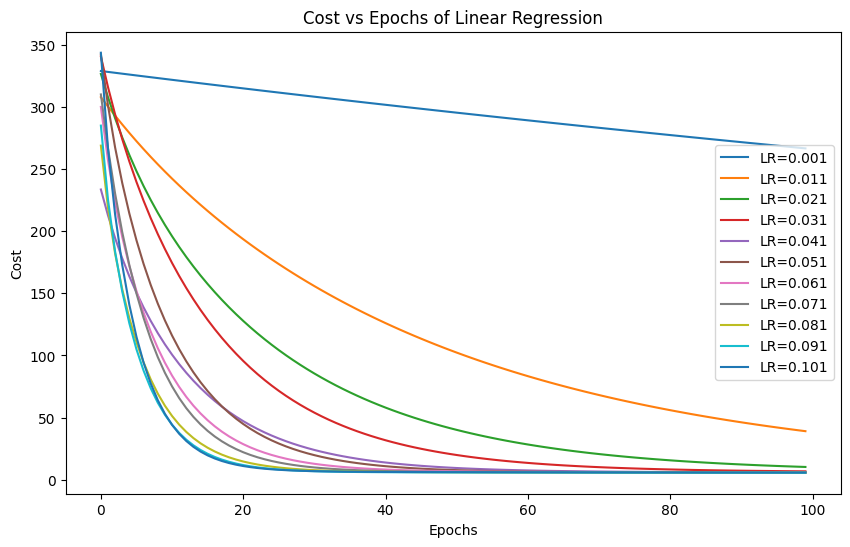

In [16]:
# Plotting the cost
plt.figure(figsize=(10, 6))
for lr in Costs.columns:
    plt.plot(Costs[lr], label=f'LR={round(lr, 3)}')

plt.title('Cost vs Epochs of Linear Regression')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

### Generating and Saving Models

In [17]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
for epochs in np.arange(10, 110, 10):
    for lr in [0.001, 0.01, 0.1]:
        print(f"Linear Regression with {epochs} epochs, and {lr} learning rate")

        # Defining the model for Linear Regression
        model = LinearRegression(in_features=X_train.shape[1], out_features=1, learning_rate=lr)
        model.fit(X_train, Y_train, epochs=epochs)

        # Saving the model
        filepath = os.path.join(directory, f"Linear_{lr}_{epochs}.pkl")
        with open(filepath, "wb") as file:
            pickle.dump(model, file)
        print("\n------------------------------------------------------------\n")

Linear Regression with 10 epochs, and 0.001 learning rate

------------------------------------------------------------

Linear Regression with 10 epochs, and 0.01 learning rate

------------------------------------------------------------

Linear Regression with 10 epochs, and 0.1 learning rate

------------------------------------------------------------

Linear Regression with 20 epochs, and 0.001 learning rate

------------------------------------------------------------

Linear Regression with 20 epochs, and 0.01 learning rate

------------------------------------------------------------

Linear Regression with 20 epochs, and 0.1 learning rate

------------------------------------------------------------

Linear Regression with 30 epochs, and 0.001 learning rate

------------------------------------------------------------

Linear Regression with 30 epochs, and 0.01 learning rate

------------------------------------------------------------

Linear Regression with 30 epochs, and 0

## Logistic Regression Model

### Imports and Utils

### Dataset Loading and Preprocessing

### Model Creation and Training

### Testing and Plotting

### Generating and Saving Models